# Inicio
Iremos usar um modelo de rede neural para manipular séries temporais.\
Iremos usar o NeuralProphet

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import torch
import os
import pickle

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error
)

from datetime import datetime
from neuralprophet.configure import Season
torch.serialization.add_safe_globals([Season])

import neuralprophet

In [20]:
codigo = 'BRL=X'
inicio = '2000-01-01'
fim = pd.to_datetime(datetime.now()).strftime('%Y-%m-%d')

data = yf.download(codigo, start=inicio, end=fim, multi_level_index=False)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_130323/117030692.py:5: FutureWarning:

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [21]:
# Transformando em dataframe
df = pd.DataFrame(data)

# Transformando dados
df = df[['Close']].reset_index()
df.columns = ['ds', 'y']

## Modelo
Iremos treinar o modelo com os dados

In [22]:
df_formatted = pd.DataFrame({
    'ds': pd.to_datetime(df['ds']),
    'y': df['y'].astype(float)
})
df_formatted = df_formatted.dropna()
df_formatted = df_formatted.sort_values('ds').reset_index(drop=True)

In [112]:
modelo = neuralprophet.NeuralProphet(
    growth='linear',
    changepoints_range=0.9,
    n_changepoints=25,

    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,

    batch_size=32,
    learning_rate=0.01,

    seasonality_mode='multiplicative',
    normalize='minmax',

    trend_reg=0.01,
    ar_reg=0.01,

    n_forecasts=1,

    trend_reg_threshold=False
)
metrics = modelo.fit(
    df_formatted,
    freq='D',
    validation_df=None,
    progress='bar'
    )

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change

Epoch 70: 100%|██████████| 70/70 [00:00<00:00, 145.82it/s, loss=0.00426, v_num=23, MAE=0.208, RMSE=0.262, Loss=0.00448, RegLoss=0.000348]  


### Testando modelo

In [113]:
dados_futuros = modelo.make_future_dataframe(df_formatted, periods=365)
previsao_futura = modelo.predict(dados_futuros)

previsoes_historicas = modelo.predict(df_formatted)

WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.541% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.




Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 429.48it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.541% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be re


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 356.84it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [114]:
previsao_futura.head()

,ds,y,yhat1,trend,season_yearly
0,2025-09-11,None,5.987293,5.976585,0.010708
1,2025-09-12,None,5.994521,5.977793,0.016728
2,2025-09-13,None,6.001746,5.979002,0.022744
3,2025-09-14,None,6.008925,5.980211,0.028714
4,2025-09-15,None,6.016069,5.981419,0.034650


In [109]:
modelo.plot_components(previsao_futura)

ERROR - (NP.plotly.plot_components) - plotly-resampler is not installed. Please install it to use the resampler.
WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:283: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:410: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




### Visualizando previsão

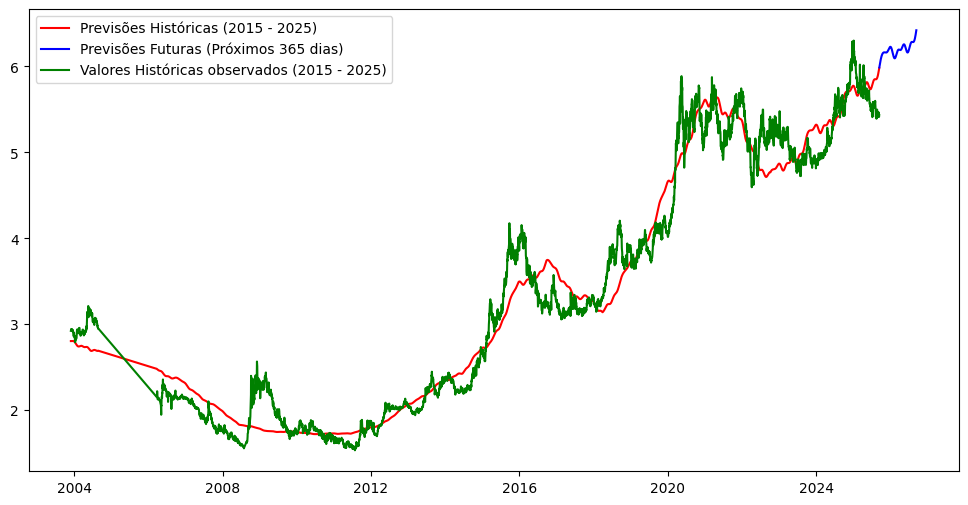

In [115]:
plt.figure(figsize=(12, 6))

# Previsão histórica
plt.plot(
    previsoes_historicas['ds'],
    previsoes_historicas['yhat1'],
    label='Previsões Históricas (2015 - 2025)',
    c='r',
)

# Previsão futura
plt.plot(
    previsao_futura['ds'],
    previsao_futura['yhat1'],
    label='Previsões Futuras (Próximos 365 dias)',
    c='b',
)

# Dados históricos
plt.plot(
    df_formatted['ds'],
    df_formatted['y'],
    label='Valores Históricas observados (2015 - 2025)',
    c='g',
)

plt.legend()
plt.show()

### Avaliando modelo

In [116]:
# R2 mede quanto da variância dos dados é explicada pelo seu modelo
r2_score(y_true=previsoes_historicas['y'], y_pred=previsoes_historicas['yhat1'])

# Quanto mais próximo de 1 é melhor

0.9649124054168299

In [120]:
# MSE (Erro médio absoluto)
mean_absolute_error(y_true=previsoes_historicas['y'], y_pred=previsoes_historicas['yhat1'])

# Erro médio que o modelo tem
# Quanto menor melhor

0.20756878300194254

In [121]:
# Porcentagem média de erro
mean_absolute_percentage_error(y_true=previsoes_historicas['y'], y_pred=previsoes_historicas['yhat1']) * 100

# Quanto menor melhor

6.649846965509185

### Salvando modelo

In [12]:
os.makedirs('./Models/Neural', exist_ok=True)

In [119]:
with open('./Models/Neural/neural_model_v2.pkl', 'wb') as f:
    pickle.dump(modelo, f)

print("Modelo salvo com sucesso!")

Modelo salvo com sucesso!


### Carregando modelo

In [ ]:
def load_neural_model():
    with open('./Models/Neural/neural_model_v1.pkl', 'rb') as f:
        loaded_model = pickle.load(f)
    
    return loaded_model

loaded_model = load_neural_model()